In [1]:
!pip install librosa soundfile scikit-learn


In [2]:
import os
import csv
import tarfile
import urllib.request
import random
import numpy as np
import librosa
import tensorflow as tf
import soundfile as sf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt


In [3]:
dataset_url = 'http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz'
dataset_tar = 'speech_commands_v0.02.tar.gz'
data_dir = 'speech_commands'
os.makedirs(data_dir, exist_ok=True)

if not os.path.exists(dataset_tar):
    print("Downloading dataset...")
    urllib.request.urlretrieve(dataset_url, dataset_tar)
    print("Download complete.")

print("Extracting dataset...")
with tarfile.open(dataset_tar, 'r:gz') as tar:
    tar.extractall(path=data_dir)
print("Extraction complete.")


Download complete.
Extracting dataset...
Extraction complete.


In [4]:
keywords = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
all_data = []

for kw in keywords:
    files = [os.path.join(data_dir, kw, f) for f in os.listdir(os.path.join(data_dir, kw)) if f.endswith('.wav')]
    all_data.extend([(f, kw) for f in files])

train_set, test_set = train_test_split(all_data, test_size=0.2, stratify=[lbl for _, lbl in all_data], random_state=42)
train_set, val_set = train_test_split(train_set, test_size=0.2, stratify=[lbl for _, lbl in train_set], random_state=42)

os.makedirs('splits', exist_ok=True)

def write_csv(data, filename):
    with open(os.path.join('splits', filename), 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['filepath', 'label'])
        writer.writerows(data)

write_csv(train_set, 'train.csv')
write_csv(val_set, 'val.csv')
write_csv(test_set, 'test.csv')


In [5]:
def extract_features(file_path, feature_type='mfcc', win_ms=30, overlap_perc=0.25, sr=16000, n_mels=40):
    y, sr = librosa.load(file_path, sr=sr)
    win_len = int(sr * win_ms / 1000)
    hop_len = int(win_len * (1 - overlap_perc))

    if feature_type == 'mfcc':
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_fft=win_len, hop_length=hop_len, n_mfcc=13)
        return mfcc
    elif feature_type == 'mel':
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=win_len, hop_length=hop_len, n_mels=n_mels)
        mel_db = librosa.power_to_db(mel, ref=np.max)
        return mel_db
    else:
        raise ValueError("Unknown feature type")


In [6]:
label_map = {k: i for i, k in enumerate(keywords)}

def load_split(csv_path, feature_type='mfcc', win_ms=30, overlap=0.25, max_frames=100):
    X, y = [], []
    with open(csv_path, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            try:
                features = extract_features(row['filepath'], feature_type, win_ms, overlap)
                if features.shape[1] > max_frames:
                    features = features[:, :max_frames]
                else:
                    pad_width = max_frames - features.shape[1]
                    features = np.pad(features, ((0, 0), (0, pad_width)), mode='constant')
                X.append(features)
                y.append(label_map[row['label']])
            except:
                continue
    X = np.array(X, dtype='float32')
    y = to_categorical(y, num_classes=len(keywords))
    return np.expand_dims(X, -1), y


In [7]:
def build_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [20]:
# Use fixed parameters
feature_type = 'mfcc'    # Change to 'mel' if needed
win_ms = 30
overlap = 0.25

print(f"Training with feature={feature_type}, window={win_ms}ms, overlap={int(overlap * 100)}%")

X_train, y_train = load_split('splits/train.csv', feature_type, win_ms, overlap)
X_val, y_val = load_split('splits/val.csv', feature_type, win_ms, overlap)
X_test, y_test = load_split('splits/test.csv', feature_type, win_ms, overlap)

model = build_model(X_train.shape[1:], y_train.shape[1])
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=1)

loss, acc = model.evaluate(X_test, y_test, verbose=1)
print(f"\n✅ Final Test Accuracy: {acc:.4f}")


Training with feature=mfcc, window=30ms, overlap=25%
Epoch 1/20
771/771 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.1629 - loss: 3.5943 - val_accuracy: 0.5841 - val_loss: 1.1668
Epoch 2/20
771/771 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5663 - loss: 1.2230 - val_accuracy: 0.7635 - val_loss: 0.7309
Epoch 3/20
771/771 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7341 - loss: 0.7821 - val_accuracy: 0.8272 - val_loss: 0.5215
Epoch 4/20
771/771 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7918 - loss: 0.6102 - val_accuracy: 0.8622 - val_loss: 0.4289
Epoch 5/20
771/771 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8248 - loss: 0.5157 - val_accuracy: 0.8624 - val_loss: 0.4219
Epoch 6/20
771/771 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8466 - loss: 0.4512 - val_accuracy: 0.8628 - val_loss: 0.4290
Epoch 7/20
771/771 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8637 - loss: 0.4063 - val_accuracy: 0.8778 - val_loss: 0.3803
Epoch 8/20
771/771 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

In [22]:
model_dir = "trained_model"
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, f"keyword_spotting_{feature_type}_{win_ms}ms_{int(overlap * 100)}ol.h5")
model.save(model_path)
print(f"✅ Model saved to: {model_path}")


✅ Model saved to: trained_model/keyword_spotting_mfcc_30ms_25ol.h5


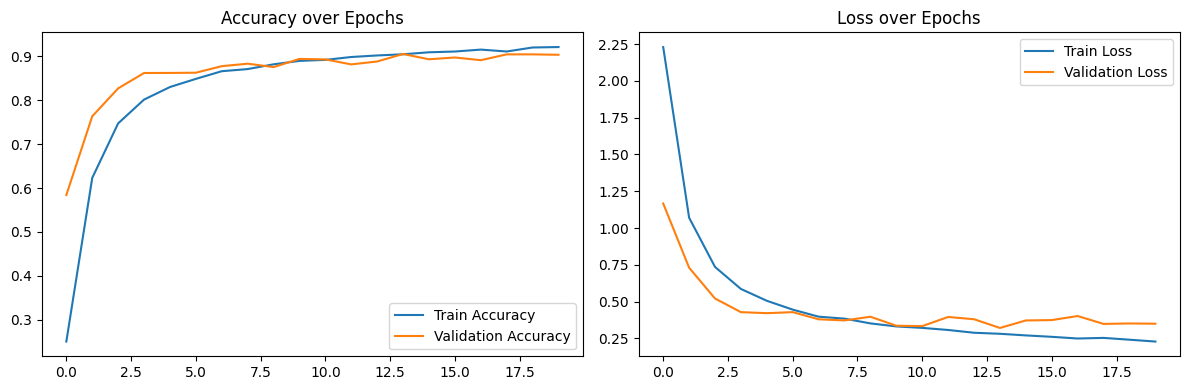

In [23]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


In [24]:
# prompt: inference the model with any of the audio files for test

# Function to make a prediction on a single audio file
def predict_keyword(audio_file_path, model, feature_type='mfcc', win_ms=30, overlap=0.25, max_frames=100):
    try:
        # Extract features from the audio file
        features = extract_features(audio_file_path, feature_type, win_ms, overlap)

        # Pad or truncate features to match the model's input shape
        if features.shape[1] > max_frames:
            features = features[:, :max_frames]
        else:
            pad_width = max_frames - features.shape[1]
            features = np.pad(features, ((0, 0), (0, pad_width)), mode='constant')

        # Reshape for model input (batch_size, height, width, channels)
        input_features = np.expand_dims(features, axis=0) # Add batch dimension
        input_features = np.expand_dims(input_features, axis=-1) # Add channel dimension

        # Make prediction
        predictions = model.predict(input_features)
        predicted_class_index = np.argmax(predictions)
        predicted_keyword = list(label_map.keys())[predicted_class_index]

        return predicted_keyword, predictions[0]

    except Exception as e:
        print(f"Error processing {audio_file_path}: {e}")
        return None, None

# Select a random audio file from the test set for inference
if test_set:
    random_test_file, true_label = random.choice(test_set)
    print(f"\n🚀 Inferencing on file: {random_test_file}")
    print(f"True label: {true_label}")

    # Load the trained model
    loaded_model = tf.keras.models.load_model(model_path) # Use the path where the model was saved

    # Make a prediction
    predicted_keyword, predictions = predict_keyword(random_test_file, loaded_model, feature_type, win_ms, overlap)

    if predicted_keyword:
        print(f"Predicted keyword: {predicted_keyword}")
        print(f"Prediction probabilities: {predictions}")
        # Optional: map probabilities to keywords
        prob_dict = {kw: prob for kw, prob in zip(keywords, predictions)}
        print("Probabilities per keyword:")
        for kw, prob in prob_dict.items():
            print(f"  {kw}: {prob:.4f}")
    else:
        print("Failed to make prediction.")
else:
    print("Test set is empty. Cannot perform inference.")


🚀 Inferencing on file: speech_commands/left/de89e2ca_nohash_5.wav
True label: left
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
Predicted keyword: left
Prediction probabilities: [2.5796676e-11 9.5656781e-17 5.4242283e-12 1.3505511e-18 1.0000000e+00
 1.2870353e-13 1.0915719e-17 1.2654219e-10 4.0208987e-09 1.2883208e-19]
Probabilities per keyword:
  yes: 0.0000
  no: 0.0000
  up: 0.0000
  down: 0.0000
  left: 1.0000
  right: 0.0000
  on: 0.0000
  off: 0.0000
  stop: 0.0000
  go: 0.0000


In [31]:
# prompt: another inference a random file every time

# Select a random audio file from the test set for inference
if test_set:
    random_test_file, true_label = random.choice(test_set)
    print(f"\n🚀 Inferencing on file: {random_test_file}")
    print(f"True label: {true_label}")

    # Load the trained model
    # Use the path where the model was saved, ensure model_path is defined from previous cells
    loaded_model = tf.keras.models.load_model(model_path)

    # Make a prediction
    # Ensure feature_type, win_ms, overlap are defined from previous cells
    predicted_keyword, predictions = predict_keyword(random_test_file, loaded_model, feature_type, win_ms, overlap)

    if predicted_keyword:
        print(f"Predicted keyword: {predicted_keyword}")
        print(f"Prediction probabilities: {predictions}")
        # Optional: map probabilities to keywords
        # Ensure keywords are defined from previous cells
        prob_dict = {kw: prob for kw, prob in zip(keywords, predictions)}
        print("Probabilities per keyword:")
        for kw, prob in prob_dict.items():
            print(f"  {kw}: {prob:.4f}")
    else:
        print("Failed to make prediction.")
else:
    print("Test set is empty. Cannot perform inference.")


🚀 Inferencing on file: speech_commands/right/cc6ee39b_nohash_0.wav
True label: right
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
Predicted keyword: right
Prediction probabilities: [5.6581552e-11 6.1424695e-14 1.9409597e-14 3.4837528e-12 1.1636431e-02
 9.8836356e-01 6.0184011e-11 1.2532075e-16 1.8491205e-12 1.5994649e-13]
Probabilities per keyword:
  yes: 0.0000
  no: 0.0000
  up: 0.0000
  down: 0.0000
  left: 0.0116
  right: 0.9884
  on: 0.0000
  off: 0.0000
  stop: 0.0000
  go: 0.0000
